In [117]:
import pandas as pd
from datetime import datetime as DateTime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Configurando los estílos de los gráficos
plt.ioff()
sns.set_context('talk')
sns.set_style("whitegrid")

## Adquisición de Datos

In [118]:
df = pd.read_csv('data/defunciones.csv')

In [119]:
df

,FECHA_CORTE,UUID,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,FECHA_NAC,DEPARTAMENTO,PROVINCIA,DISTRITO
0,20210504,dabd4dda01b9bddb28a4e87f80ae6df5,20200521,73,MASCULINO,19470220.0,LIMA,LIMA,ATE
1,20210504,a7eccdc8c5d5bb08d6a6714a1953c175,20200521,25,MASCULINO,19950410.0,LIMA,LIMA,CHORRILLOS
2,20210504,37b045514b0d98948f93ce777f5e3114,20200521,46,MASCULINO,19731001.0,LIMA,LIMA,INDEPENDENCIA
3,20210504,80add061b48b602a09bf21af5d35982a,20200521,67,MASCULINO,19520827.0,LIMA,LIMA,RIMAC
4,20210504,97eb538f8f91c75b32b7eeec73886bb9,20200521,70,FEMENINO,19500321.0,LIMA,LIMA,SAN MARTIN DE PORRES
...,...,...,...,...,...,...,...,...,...
62971,20210504,0e5a26df7787a3dcd0ee369690eb7fd7,20210430,75,FEMENINO,NaN,ICA,ICA,SANTIAGO
62972,20210504,37dc81f179884d3acac8715e0df96d2c,20210430,68,MASCULINO,NaN,CALLAO,CALLAO,CALLAO
62973,20210504,020b6554ff21cffdbf35fce898f8a956,20210430,79,FEMENINO,NaN,CALLAO,CALLAO,CALLAO
62974,20210504,cae43a5ec4753c493f5d49514965efc2,20210430,70,MASCULINO,NaN,CALLAO,CALLAO,CALLAO


## Transformación de Datos

### Calculando defunciones por día

In [120]:
gb = df.groupby(by="FECHA_FALLECIMIENTO")

In [121]:
data = []
for i in gb:
    data.append(
        {
            'date': DateTime.strptime(str(i[0]),'%Y%m%d'),
            'count': len(i[1])
        }
    )

daily = pd.DataFrame(data, columns=['date','count'])
daily.head(5)

,date,count
0,2020-03-18,3
1,2020-03-19,3
2,2020-03-20,2
3,2020-03-21,2
4,2020-03-22,4


### Calculando defunciones por semana

In [122]:
data = daily.copy()
data['low'] = data['count'].rolling(7).min()
data['high'] = data['count'].rolling(7).max()

In [123]:
weekly = data.set_index(data['date']).resample('W').agg({'date': 'last','high': 'max', 'low': 'min','count': 'last'}).reset_index(drop=True)[['date','high','low','count']]
weekly.head(5)

,date,high,low,count
0,2020-03-22,NaN,NaN,4
1,2020-03-29,16.0,2.0,16
2,2020-04-05,56.0,3.0,36
3,2020-04-12,93.0,18.0,79
4,2020-04-19,117.0,47.0,117


## Visualización de Datos

In [124]:
ema_count = daily['count'].ewm(com=9,adjust=False).mean()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

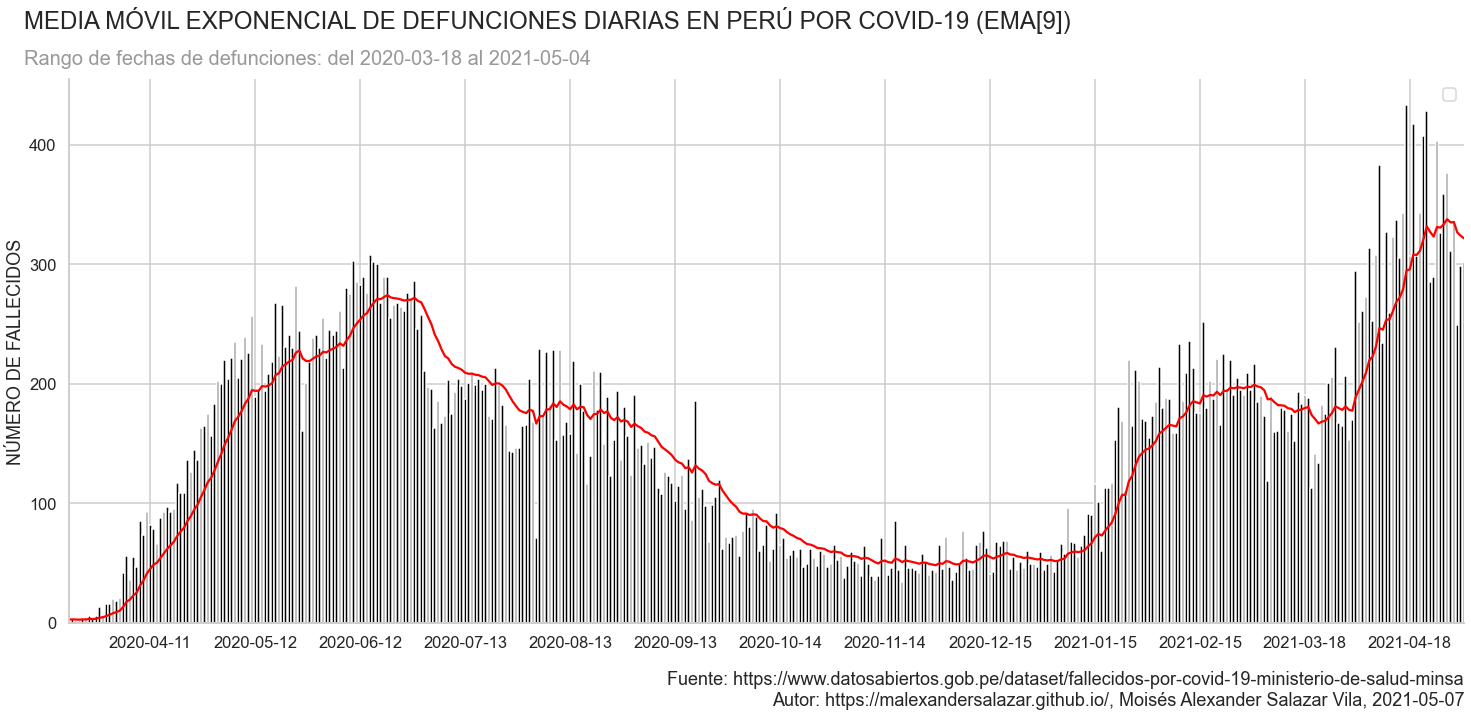

In [125]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'MEDIA MÓVIL EXPONENCIAL DE DEFUNCIONES DIARIAS EN PERÚ POR COVID-19 (EMA[9])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.bar(daily['date'], daily['count'], color='#000')
axs.plot(daily['date'], ema_count, color='r')

axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('NÚMERO DE FALLECIDOS')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/DEFUNCIONES.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [126]:
low_in_period = weekly['low'].rolling(12).min()
high_in_period = weekly['high'].rolling(12).max()
percentK = pd.Series((weekly['count'] - low_in_period) / (high_in_period - low_in_period) * 100, name='%K')
percentD = pd.Series(percentK.rolling(3).mean(), name='%D')
percentDn = pd.Series(percentD.rolling(3).mean(), name='%Dn')

<Figure size 432x288 with 0 Axes>

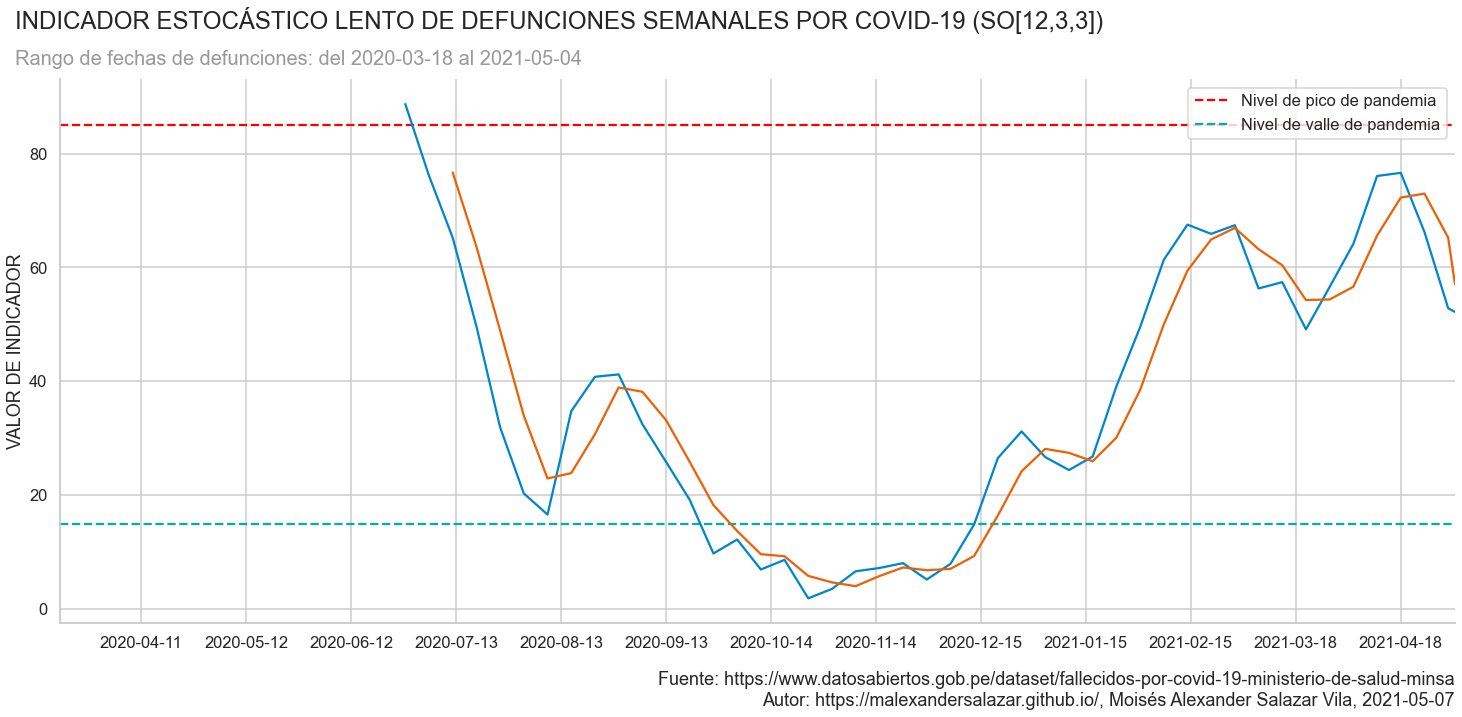

In [127]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR ESTOCÁSTICO LENTO DE DEFUNCIONES SEMANALES POR COVID-19 (SO[12,3,3])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], percentD, color='#0086CD')
axs.plot(weekly['date'], percentDn, color='#EC6106')
axs.hlines(85, daily["date"].iat[0], daily["date"].iat[-1], color='r', linestyles= 'dashed', label='Nivel de pico de pandemia')
axs.hlines(15, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de valle de pandemia')

# axs.set_xlim((weekly["date"].iat[PERIOD],daily["date"].iat[-1]))
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/SO.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [128]:
daily_delta = daily['count'].diff()
daily_up = daily_delta.clip(lower=0)
daily_down = -1*daily_delta.clip(upper=0)

ema_up = daily_up.ewm(com=26,adjust=False).mean()
ema_down = daily_down.ewm(com=26,adjust=False).mean()
daily_rs = ema_up/ema_down
daily_rsi = 100-(100/(1+daily_rs))

weekly_delta = weekly['count'].diff()
weekly_up = weekly_delta.clip(lower=0)
weekly_down = -1*weekly_delta.clip(upper=0)

ema_up = weekly_up.ewm(com=PERIOD-1,adjust=False).mean()
ema_down = weekly_down.ewm(com=PERIOD-1,adjust=False).mean()
weekly_rs = ema_up/ema_down
weekly_rsi = 100-(100/(1+weekly_rs))
weekly_rsi.fillna(method='bfill',inplace=True)

<Figure size 432x288 with 0 Axes>

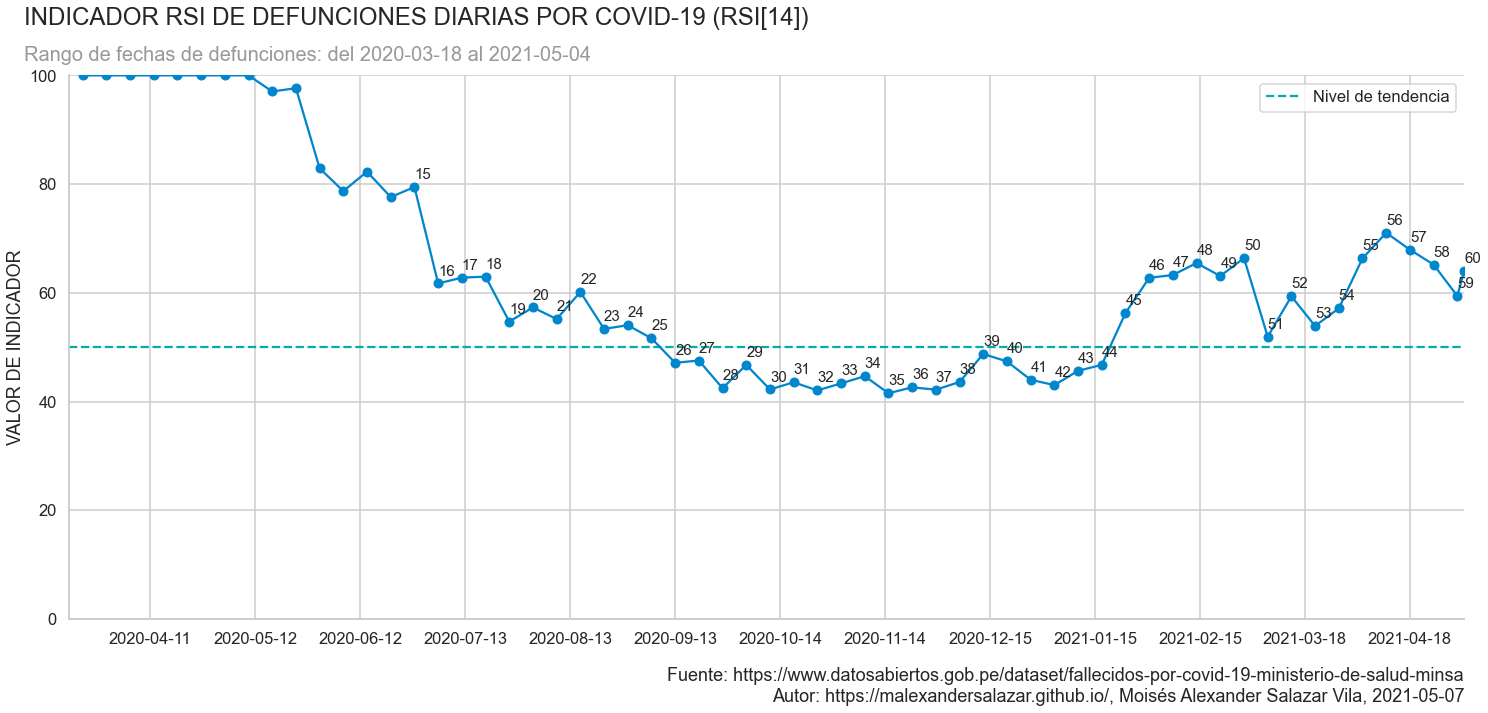

In [129]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR RSI DE DEFUNCIONES DIARIAS POR COVID-19 (RSI[14])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], weekly_rsi, 'o-', color='#0086CD')
axs.hlines(50, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de tendencia')

for i in range(14,len(weekly['date'])):
    axs.text(weekly['date'].iat[i], weekly_rsi.iat[i] + 1.5, str(i+1), fontsize='small')

axs.set_ylim(0,100)
# axs.set_xlim((weekly["date"].iat[PERIOD],daily["date"].iat[-1]))
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/RSI.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)